
# U-Net for brain MRI

*Author: mateuszbuda*

<img src="https://pytorch.org/assets/images/unet_brain_mri.png" alt="alt" width="50%"/>

## 載入U-Net預先訓練模型

In [1]:
import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in C:\Users\mikec/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


## 模型結構

In [2]:
model

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

Loads a U-Net model pre-trained for abnormality segmentation on a dataset of brain MRI volumes [kaggle.com/mateuszbuda/lgg-mri-segmentation](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation)
The pre-trained model requires 3 input channels, 1 output channel, and 32 features in the first layer.

### Model Description

This U-Net model comprises four levels of blocks containing two convolutional layers with batch normalization and ReLU activation function, and one max pooling layer in the encoding part and up-convolutional layers instead in the decoding part.
The number of convolutional filters in each block is 32, 64, 128, and 256.
The bottleneck layer has 512 convolutional filters.
From the encoding layers, skip connections are used to the corresponding layers in the decoding part.
Input image is a 3-channel brain MRI slice from pre-contrast, FLAIR, and post-contrast sequences, respectively.
Output is a one-channel probability map of abnormality regions with the same size as the input image.
It can be transformed to a binary segmentation mask by thresholding as shown in the example below.

### Example

Input images for pre-trained model should have 3 channels and be resized to 256x256 pixels and z-score normalized per volume.

## 下載一個範例圖檔

In [3]:
import urllib

url="https://github.com/mateuszbuda/brain-segmentation-pytorch/" + \
    "raw/master/assets/TCGA_CS_4944.png"
filename = "U_Net/TCGA_CS_4944.png"
urllib.request.urlretrieve(url, filename)

('U_Net/TCGA_CS_4944.png', <http.client.HTTPMessage at 0x226b53352b0>)

## 預測

In [11]:
import numpy as np
from PIL import Image
from torchvision import transforms

# 開啟檔案
input_image = Image.open(filename)

# 計算圖像的平均值及標準差
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))

# 轉換
preprocess = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize(mean=m, std=s),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

# 如果有GPU，將資料、模型轉至 GPU
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model = model.to('cuda')

# 預測    
with torch.no_grad():
    output = model(input_batch)

# 顯示有不正常部位的機率    
print(torch.round(output[0]))

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')


## 比較原圖與預測結果

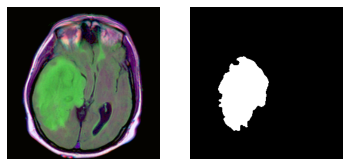

In [20]:
import matplotlib.pyplot as plt

# 原圖
plt.subplot(1,2,1)
plt.imshow(plt.imread(filename))
plt.axis('off')

# 預測結果
plt.subplot(1,2,2)
plt.imshow(torch.round(output[0]).cpu().numpy().reshape(256, 256), cmap='gray')
plt.axis('off')
plt.show()

## 將陣列轉成字串，存檔後以記事本觀察。

In [13]:
arr = torch.round(output[0]).cpu().numpy()[0].astype(int).astype(str)
result = ''
for i in range(arr.shape[0]):
    result += ''.join(arr[i]) + '\n'
# 存檔    
with open('U_Net/result.txt', 'w') as f:
    f.write(result)

### References

- [Association of genomic subtypes of lower-grade gliomas with shape features automatically extracted by a deep learning algorithm](http://arxiv.org/abs/1906.03720)
- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)
- [Brain MRI segmentation dataset](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation)